In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
#from src.models.som import SOM
from src.models.multiple_models_pyod import SU_OD
from src.models.enc_pyod import AutoEnc
from src.models.mo_gaal import MGAAL
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF as PLOF
from pyod.models.ecod import ECOD


In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [5]:
data_train = pd.read_csv('data2019_train.csv', index_col=[0], parse_dates=True)
display(data_train.head())

data_test = pd.read_csv('data2019_test.csv', index_col=[0], parse_dates=True)
data_test = data_test.rename(columns={'Attack LABLE (1:No Attack, -1:Attack)': 'anomaly'})
data_test['anomaly'] = data_test['anomaly'].apply(lambda x: 0 if x==1 else 1)

display(data_test.head())

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
2017-09-25 18:00:01,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:02,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:03,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:04,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68
2017-09-25 18:00:05,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68


,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,anomaly
2017-10-09 18:00:01,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:02,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:03,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:04,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:05,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0


In [6]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index(['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS'], dtype='object')

deleting constant features: ['1_LS_001_AL', '1_LS_002_AL', '1_P_002_STATUS', '1_P_004_STATUS', '2_MV_001_STATUS', '2_MV_002_STATUS', '2_MV_004_STATUS', '2_MV_005_STATUS', '2_MV_009_STATUS', '2_P_004_STATUS', '2_SV_101_STATUS', '2_SV_201_STATUS', '2_SV_301_STATUS', '2_SV_401_STATUS', '2_SV_501_STATUS', '2_SV_601_STATUS', '3_LS_001_AL', '3_MV_001_STATUS', '3_MV_002_STATUS', '3_MV_003_STATUS', '3_P_001_STATUS', '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS', 'PLANT_START_STOP_LOG']


In [7]:
bad_col = ['3_AIT_002_PV', '2B_AIT_002_PV']

In [8]:
summary = {}

## Подготовка train/test

In [9]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)


Standard scaler 
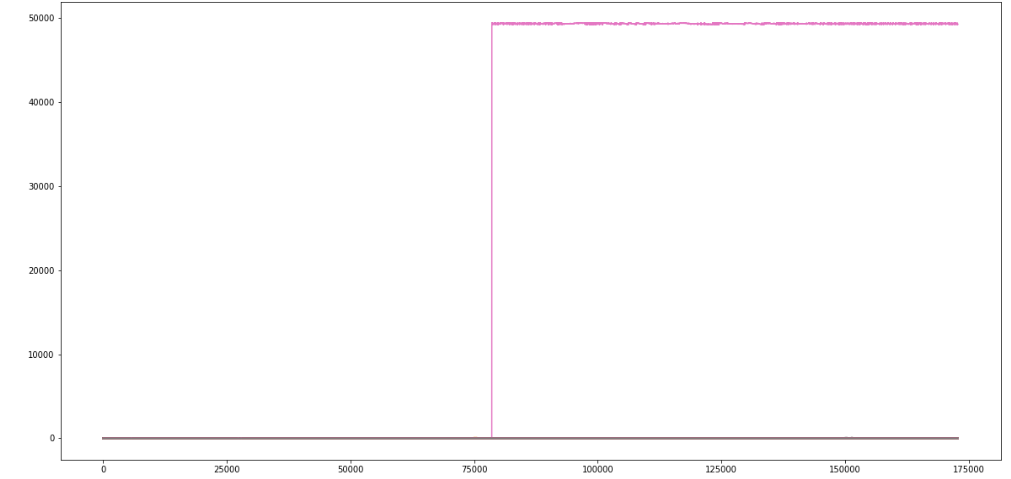

MinMax scaler
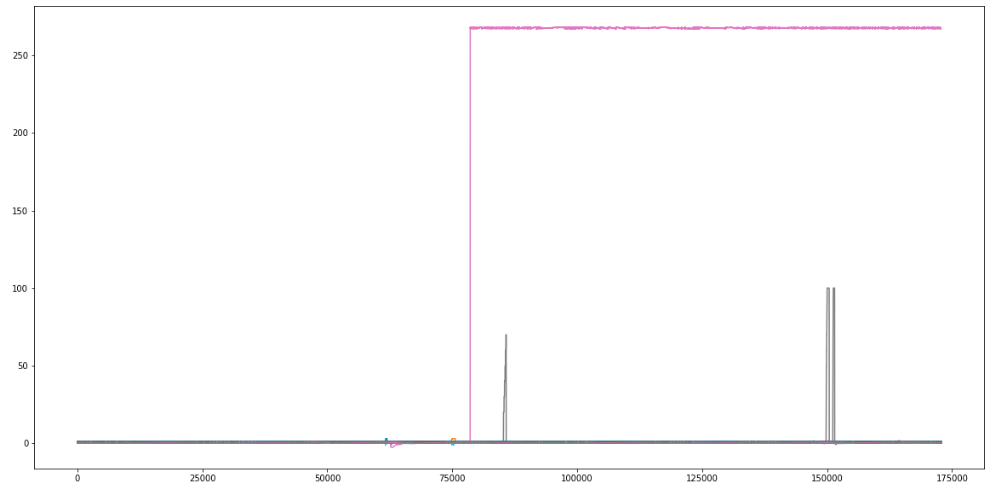

## OC SVM

In [11]:
description='WADI_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-15 15:11:40.170952: can't find saved model, fit model...


In [ ]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Удаление плохих признаков

In [13]:
bad_col

['3_AIT_002_PV', '2B_AIT_002_PV']

In [14]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 88.5%

Counter({1: 162824, -1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


In [15]:
description='WADI_svm_wo_badcol'
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

2022-09-15 15:24:05.884804: can't find saved model, fit model...


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Scaling... (MinMax)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-08-28 20:41:12.284350: find saved model: ./saved_models/WADI_svm_wo_badcol_minmax.joblib, loading...
WADI_svm_wo_badcol_minmax
f1_score: 0.48
accuracy_score: 0.95
precision_score: 0.58
recall_score: 0.42


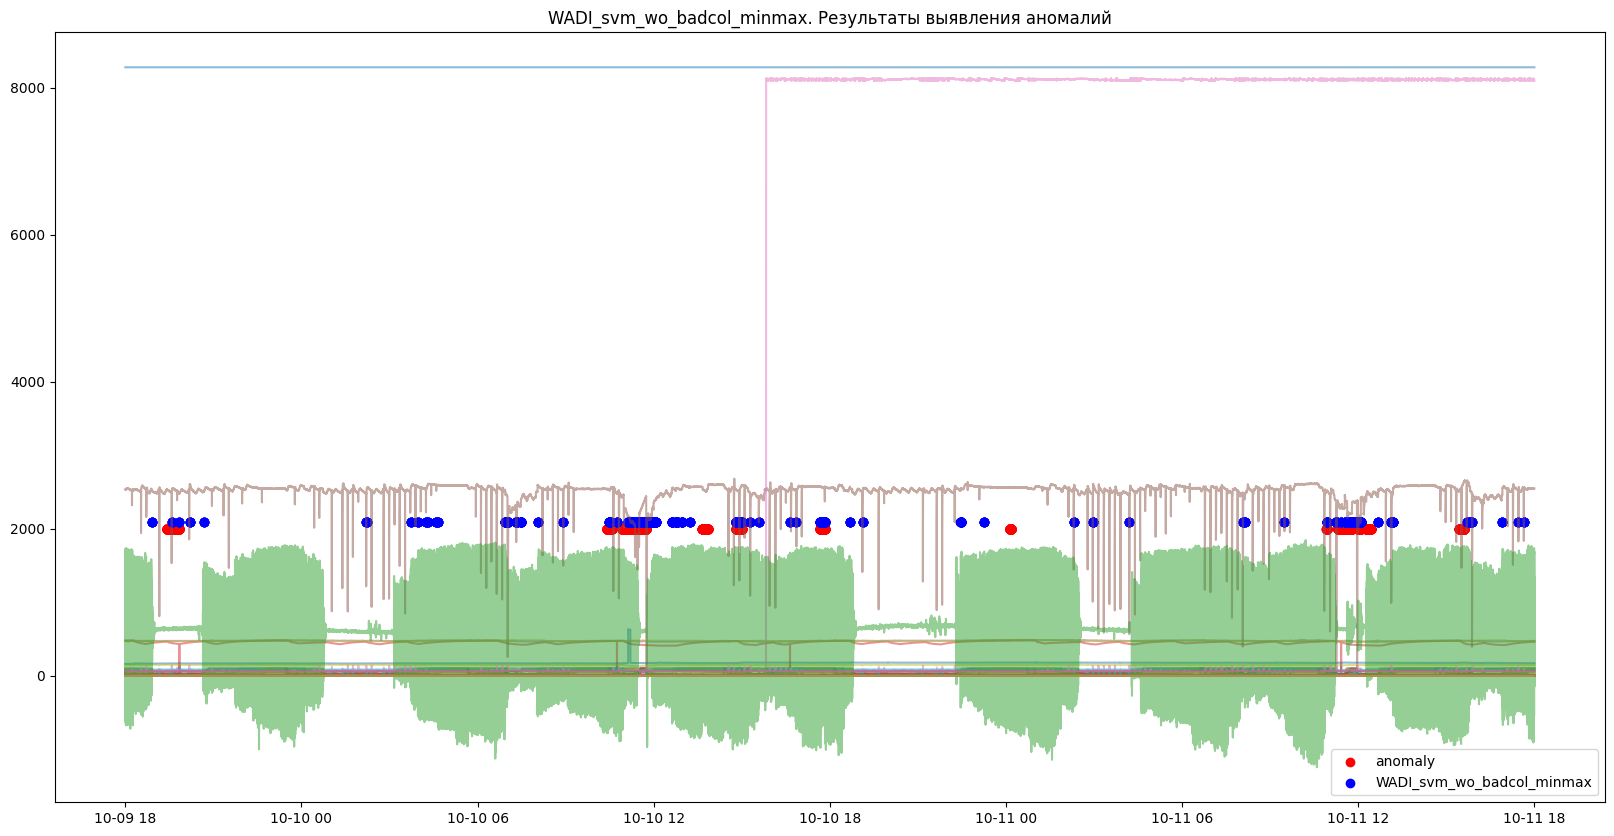

In [ ]:
description='WADI_svm_wo_badcol_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [25]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [26]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


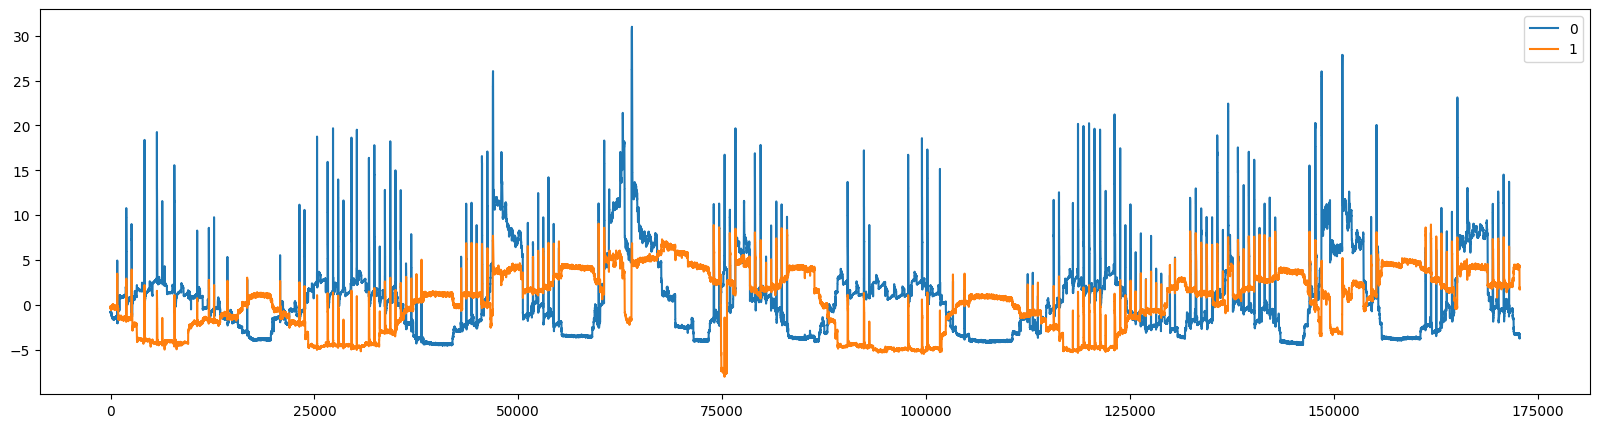

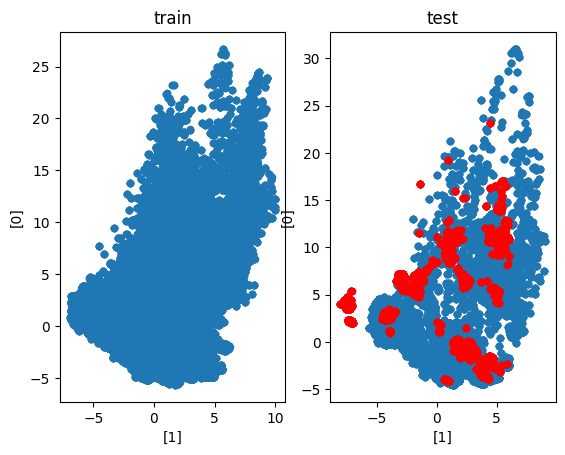

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

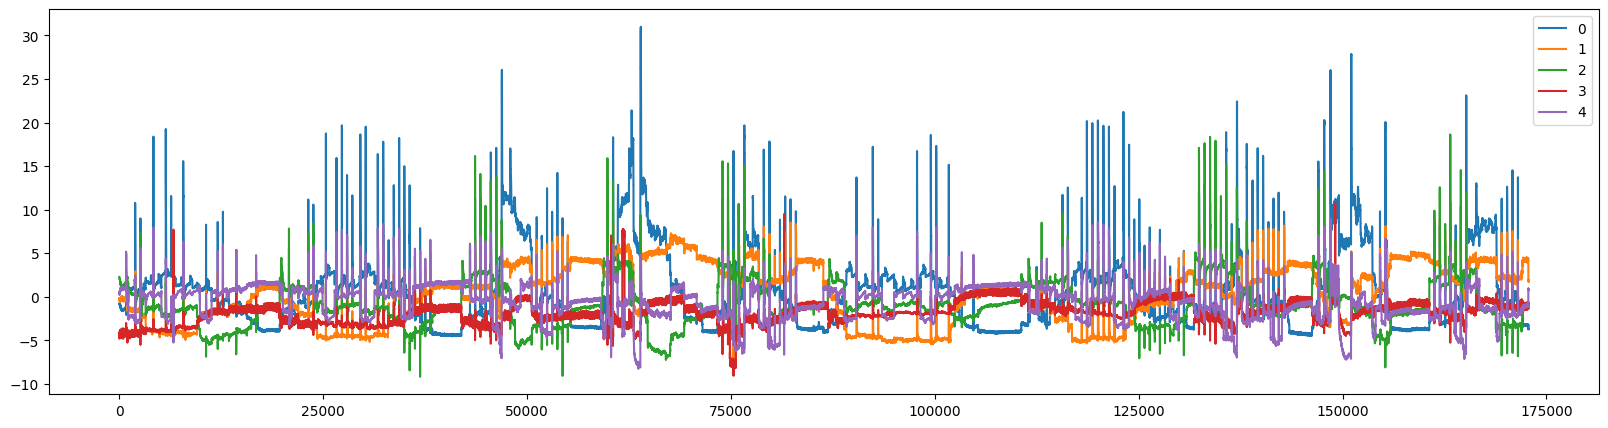

In [28]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [29]:
model = LOF()

2022-08-28 20:43:01.141547: find saved model: ./saved_models/WADI_lof_wo_badcol_n5.joblib, loading...
Train prediction score statistics
            min: -89.34863693139621
            mean: -1.100751834185035
            max: -0.8197120851279738


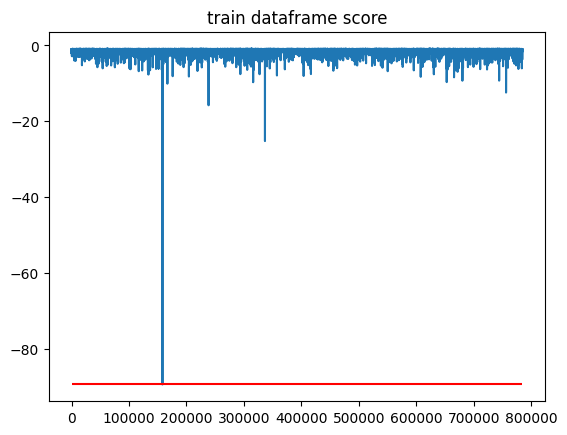

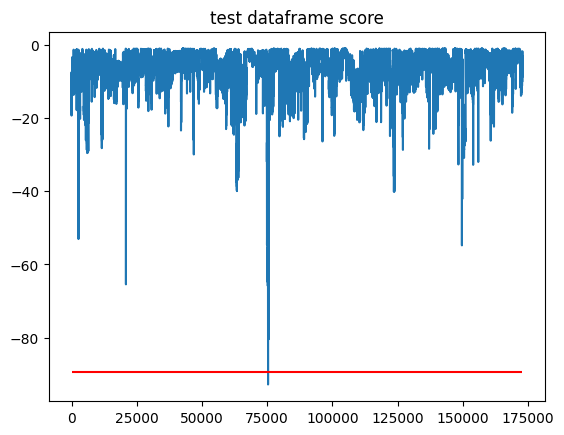

WADI_lof_wo_badcol_n5
f1_score: 0.00
accuracy_score: 0.94
precision_score: 1.00
recall_score: 0.00


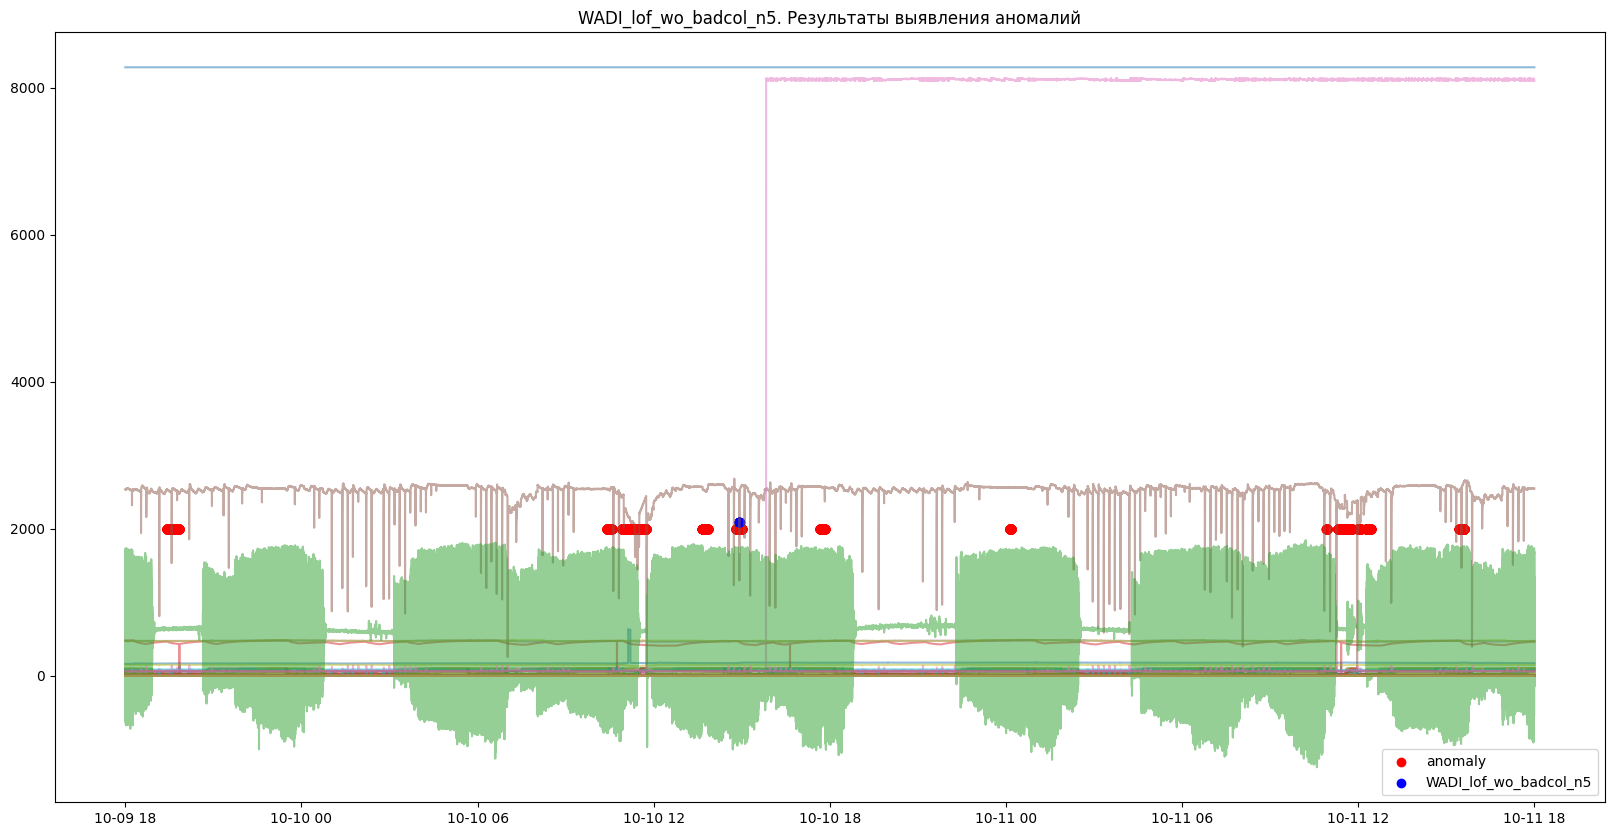

In [30]:
description = f'WADI_lof_wo_badcol_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

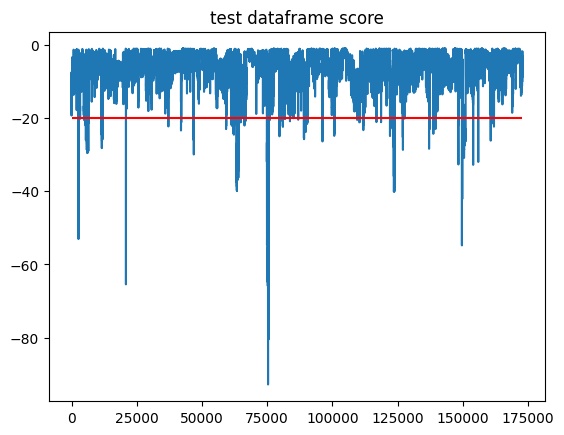

WADI_lof_wo_badcol_n5
f1_score: 0.33
accuracy_score: 0.94
precision_score: 0.52
recall_score: 0.24


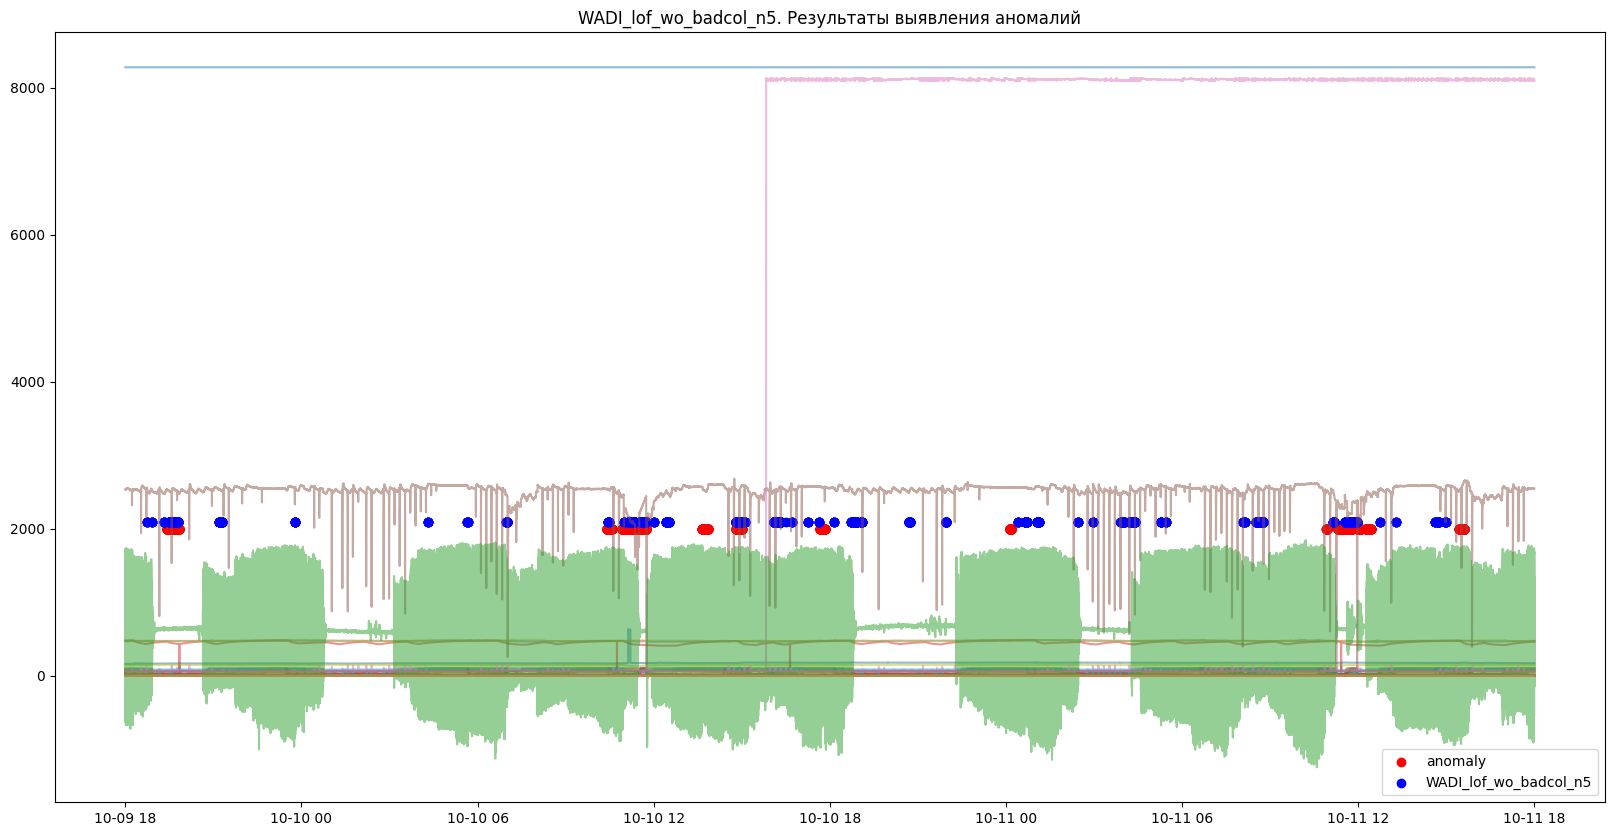

In [31]:
y_pred = predictor.get_anomalies(threshold=-20)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)
2022-08-28 20:44:14.973751: find saved model: ./saved_models/WADI_iF_default.joblib, loading...
WADI_iF_default
f1_score: 0.01
accuracy_score: 0.94
precision_score: 0.06
recall_score: 0.01


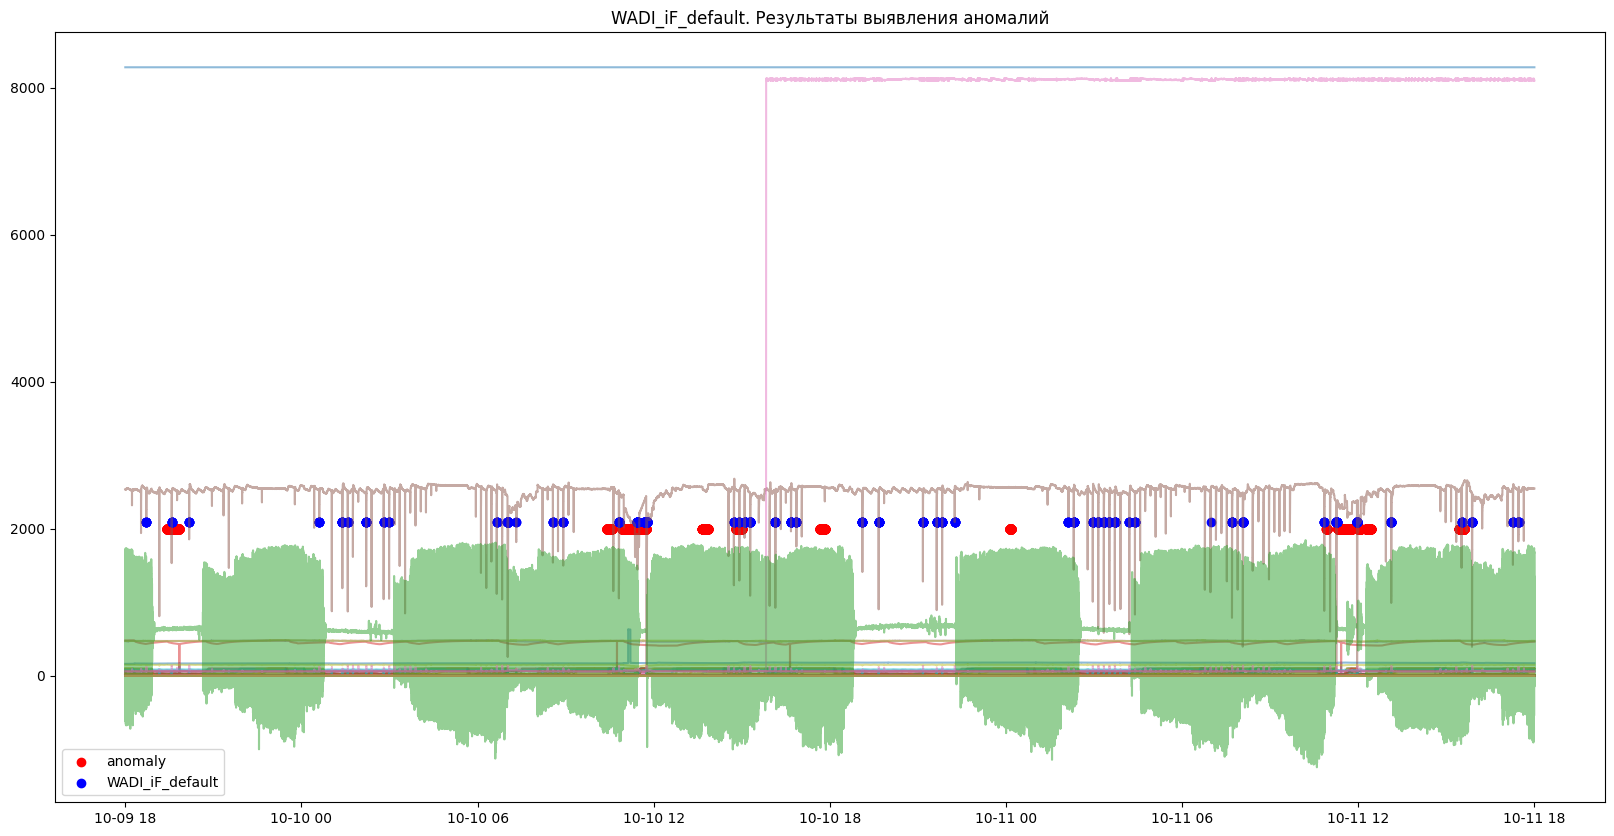

In [32]:
description = f'WADI_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-08-28 20:44:45.353487: find saved model: ./saved_models/WADI_iF_wo_badcol_n_98_c_004.joblib, loading...
WADI_iF_wo_badcol_n_98_c_004
f1_score: 0.15
accuracy_score: 0.94
precision_score: 0.37
recall_score: 0.09


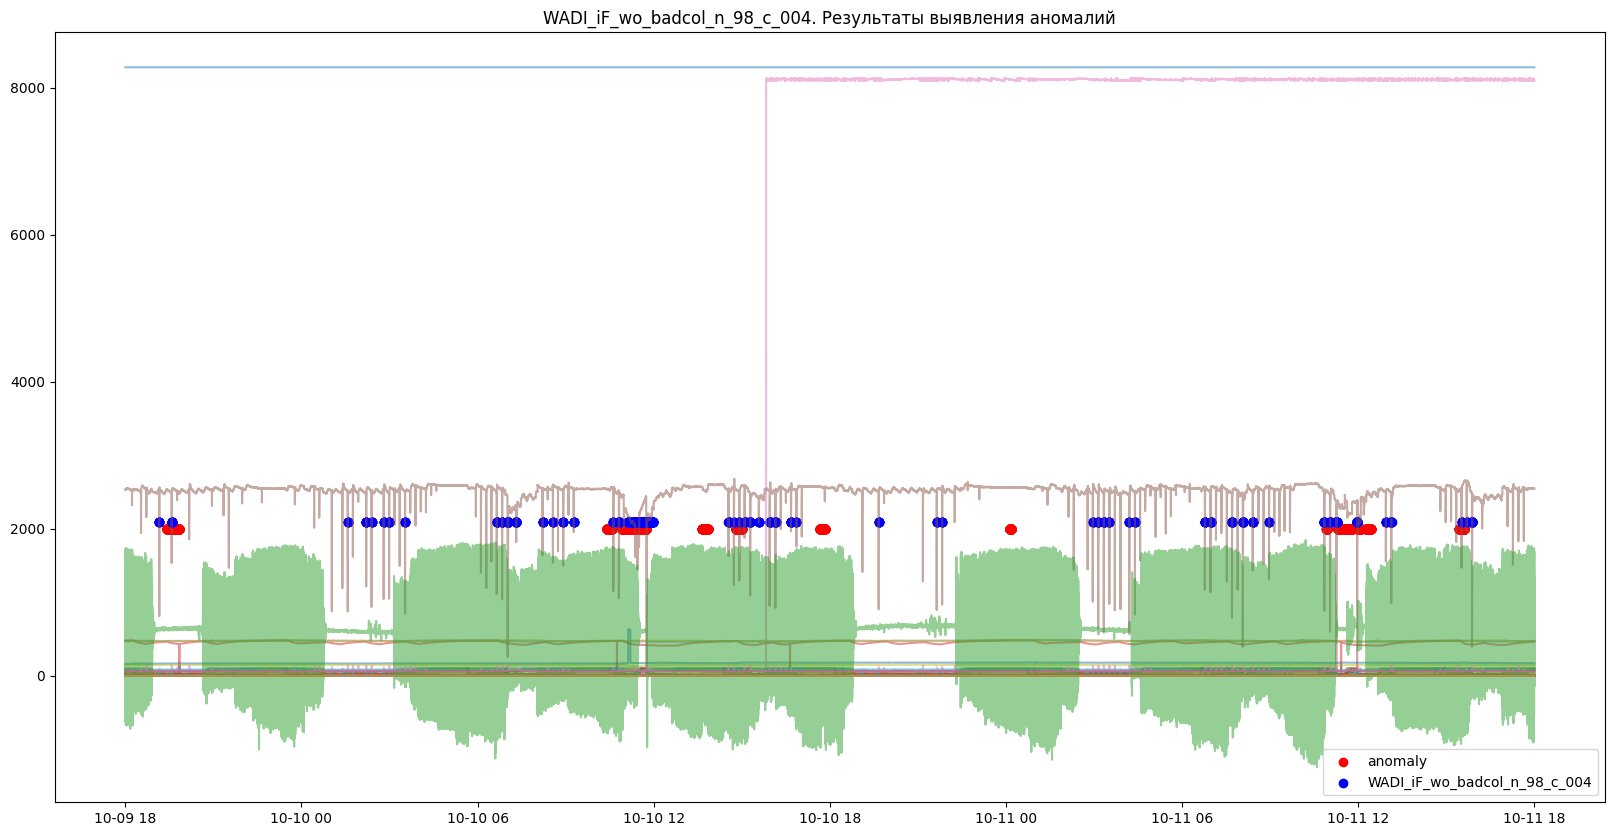

In [33]:
description = f'WADI_iF_wo_badcol_n_98_c_004'

#x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy(), scaler='MinMax')
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

model = iForest(n_estimators=98, contamination=0.004)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (T)
(1667, 98), (2881, 98), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 98)
            x_test: (172792, 10, 98)
            y_test: (172792, 10)
2022-08-28 20:10:59.334945: find saved model: ./saved_models/WADI_ae_lstm_window10_resample_T.joblib, loading...


2022-08-28 20:10:59.329387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 20:10:59.329434: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 20:10:59.329464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-test): /proc/driver/nvidia/version does not exist


3125/3125 [==============================] - 35s 11ms/step
Train prediction score statistics
            min: 5.461921976260358
            mean: 15.285930454849453
            max: 357.1489366832518


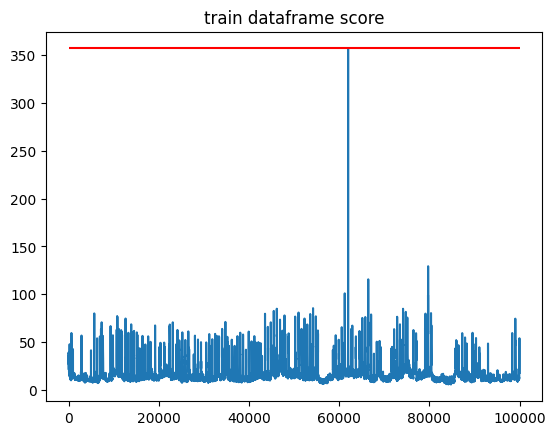

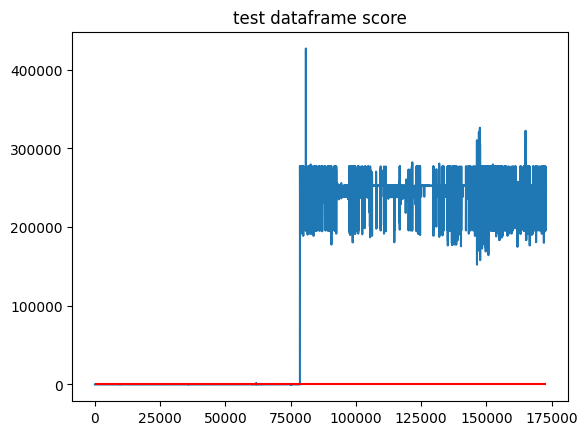

(172792,)
WADI_ae_lstm_window10_resample_T
f1_score: 0.09
accuracy_score: 0.45
precision_score: 0.05
recall_score: 0.45


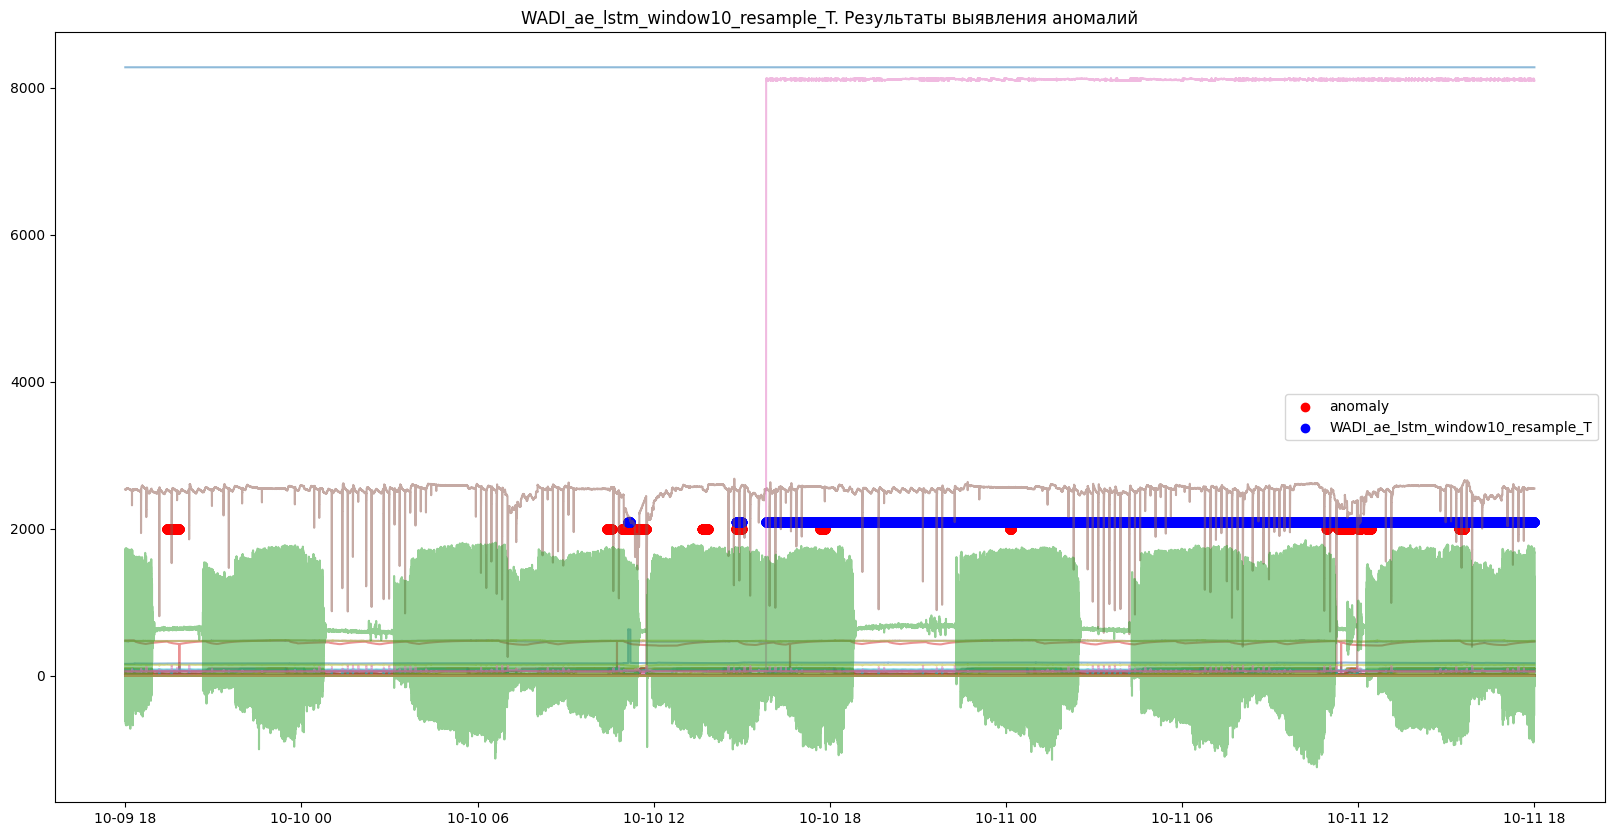

In [10]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_window{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100000].copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [11]:
del x_train, x_test, y_test
del model, predictor

In [12]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_wo_badcol_window{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (T)
(1667, 96), (2881, 96), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 96)
            x_test: (172792, 10, 96)
            y_test: (172792, 10)


2022-08-28 20:13:36.972935: find saved model: ./saved_models/WADI_ae_lstm_wo_badcol_window10_resample_T.joblib, loading...
5400/5400 [==============================] - 60s 11ms/step


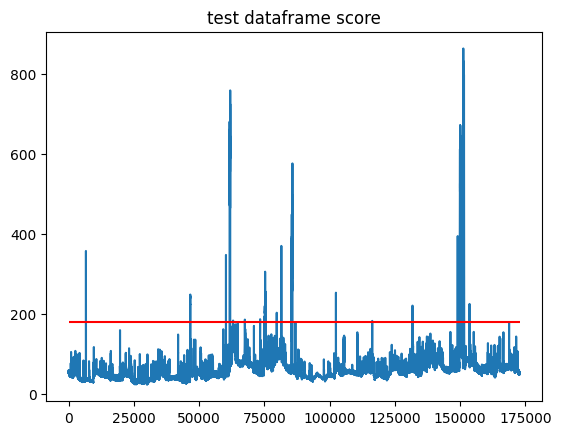

(172792,)
WADI_ae_lstm_wo_badcol_window10_resample_T
f1_score: 0.36
accuracy_score: 0.95
precision_score: 0.94
recall_score: 0.23


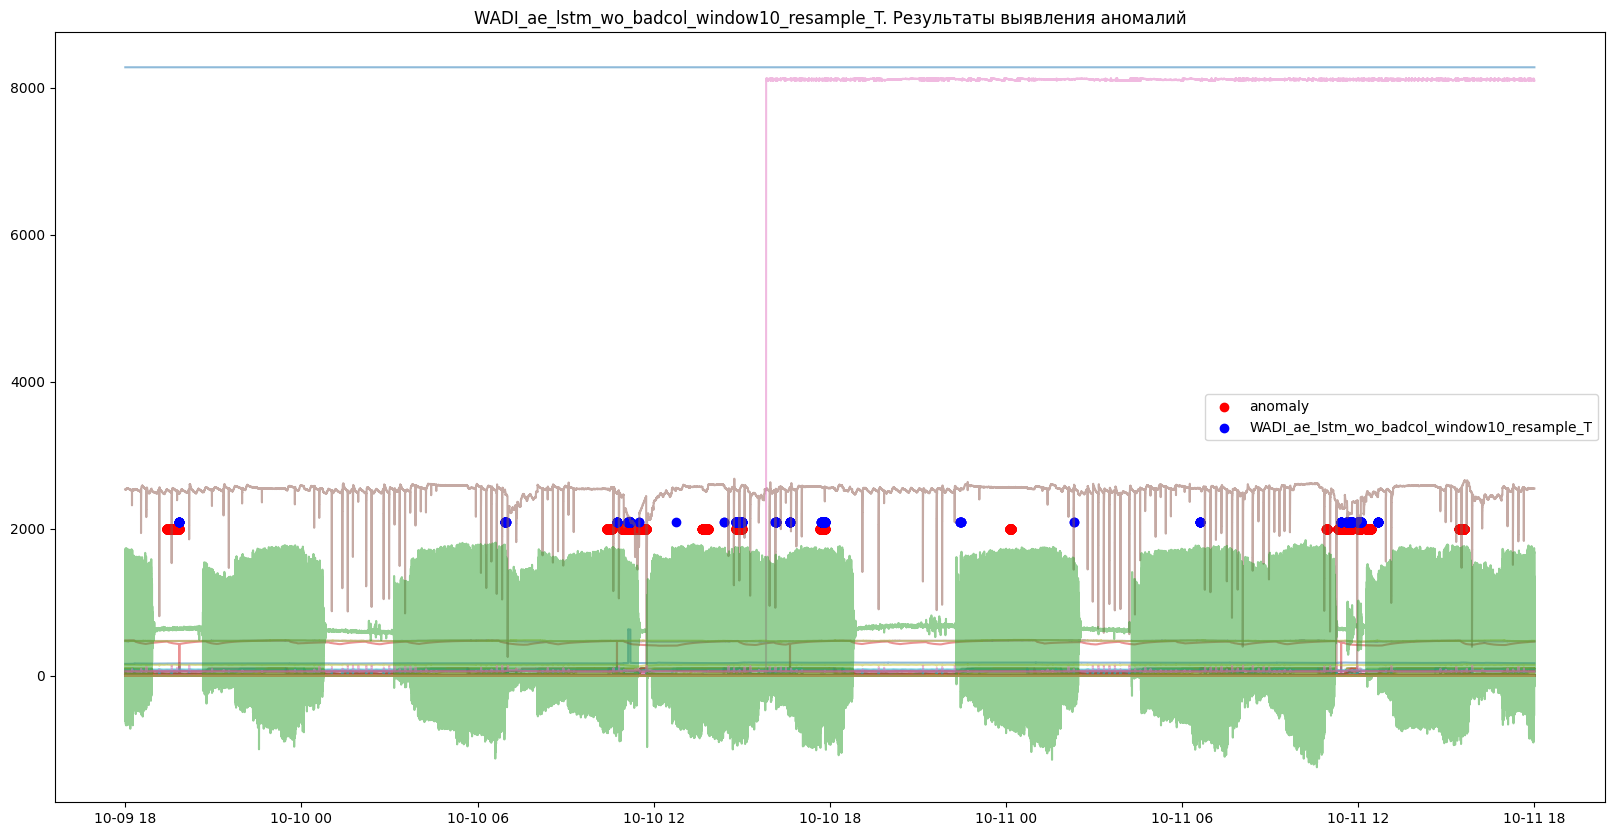

In [13]:
model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies(threshold=180)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [ ]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_wo_badcol_window{window_size}_resample_{resample_rate}_minmax'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate,
                                        scaler='MinMax')

In [ ]:
model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

3125/3125 [==============================] - 29s 9ms/step
Train prediction score statistics
            min: 1.4133974393312352
            mean: 3.467315428295647
            max: 14.258832502551531


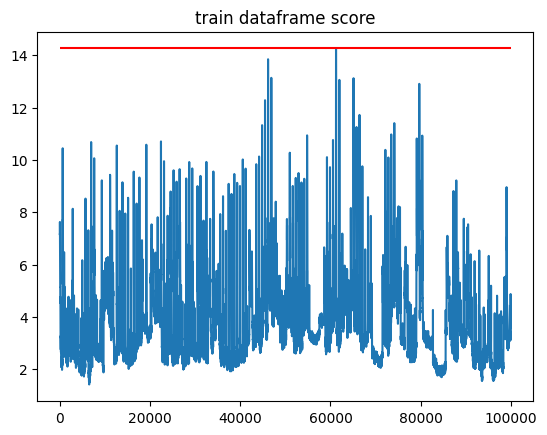

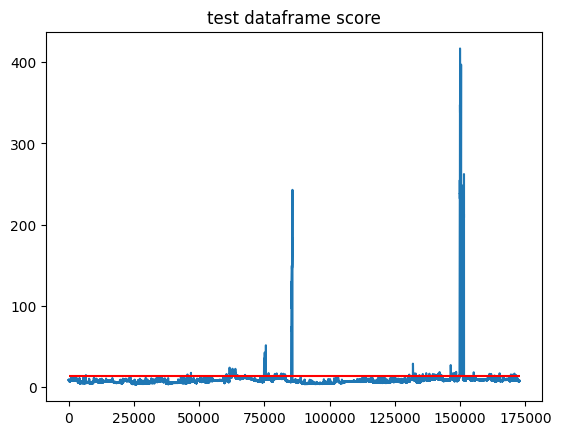

(172792,)
WADI_ae_lstm_wo_badcol_window10_resample_T_minmax
f1_score: 0.43
accuracy_score: 0.95
precision_score: 0.60
recall_score: 0.34


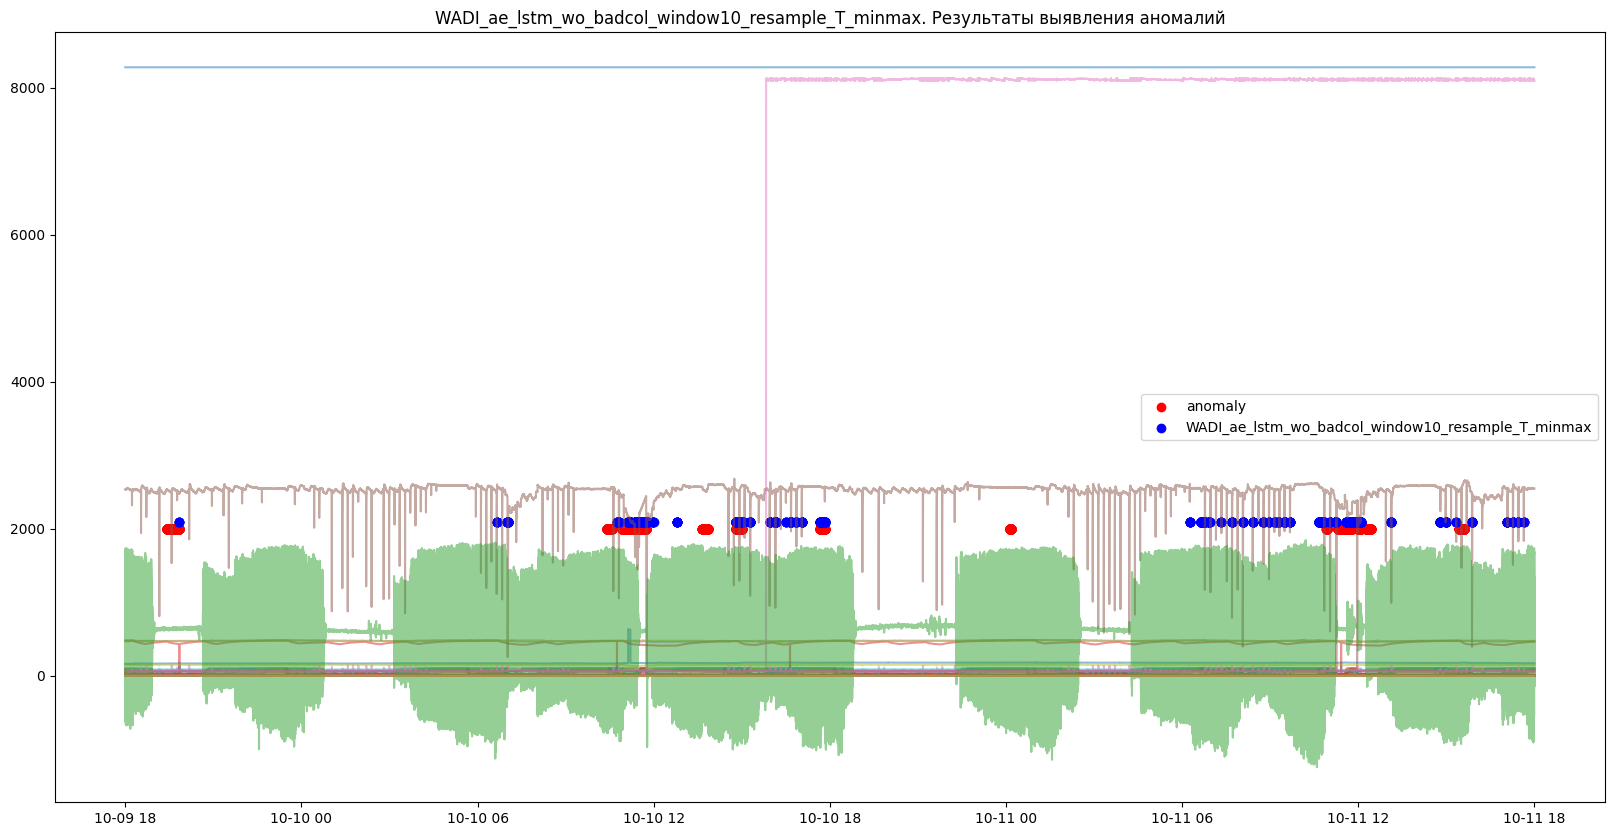

In [36]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## SOM

In [14]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


2022-08-28 20:15:47.345176: find saved model: ./saved_models/WADI_som_default.joblib, loading...


IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

Train prediction score statistics
            min: 5.057284499575796
            mean: 215.24358614284975
            max: 722.0255789647426


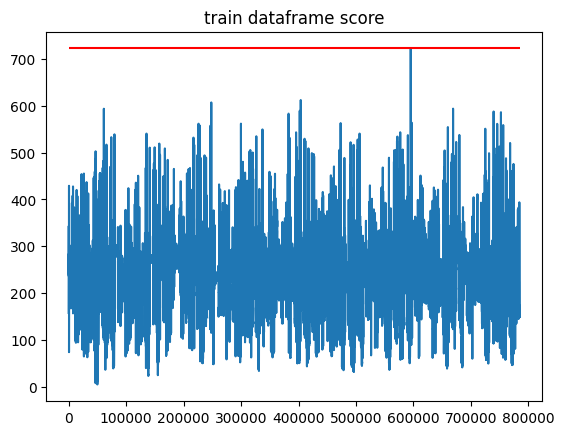

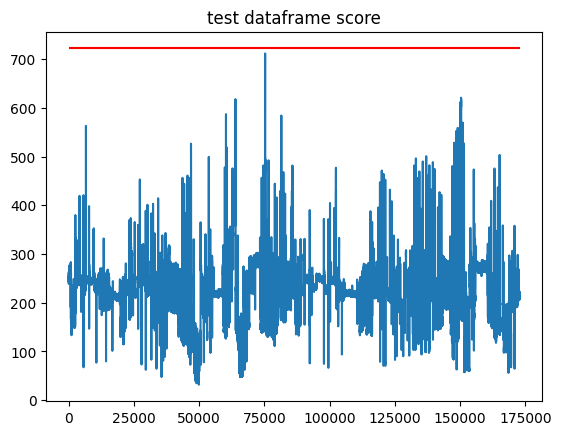

(172801,)
WADI_som_default
f1_score: 0.00
accuracy_score: 0.94
precision_score: 0.00
recall_score: 0.00


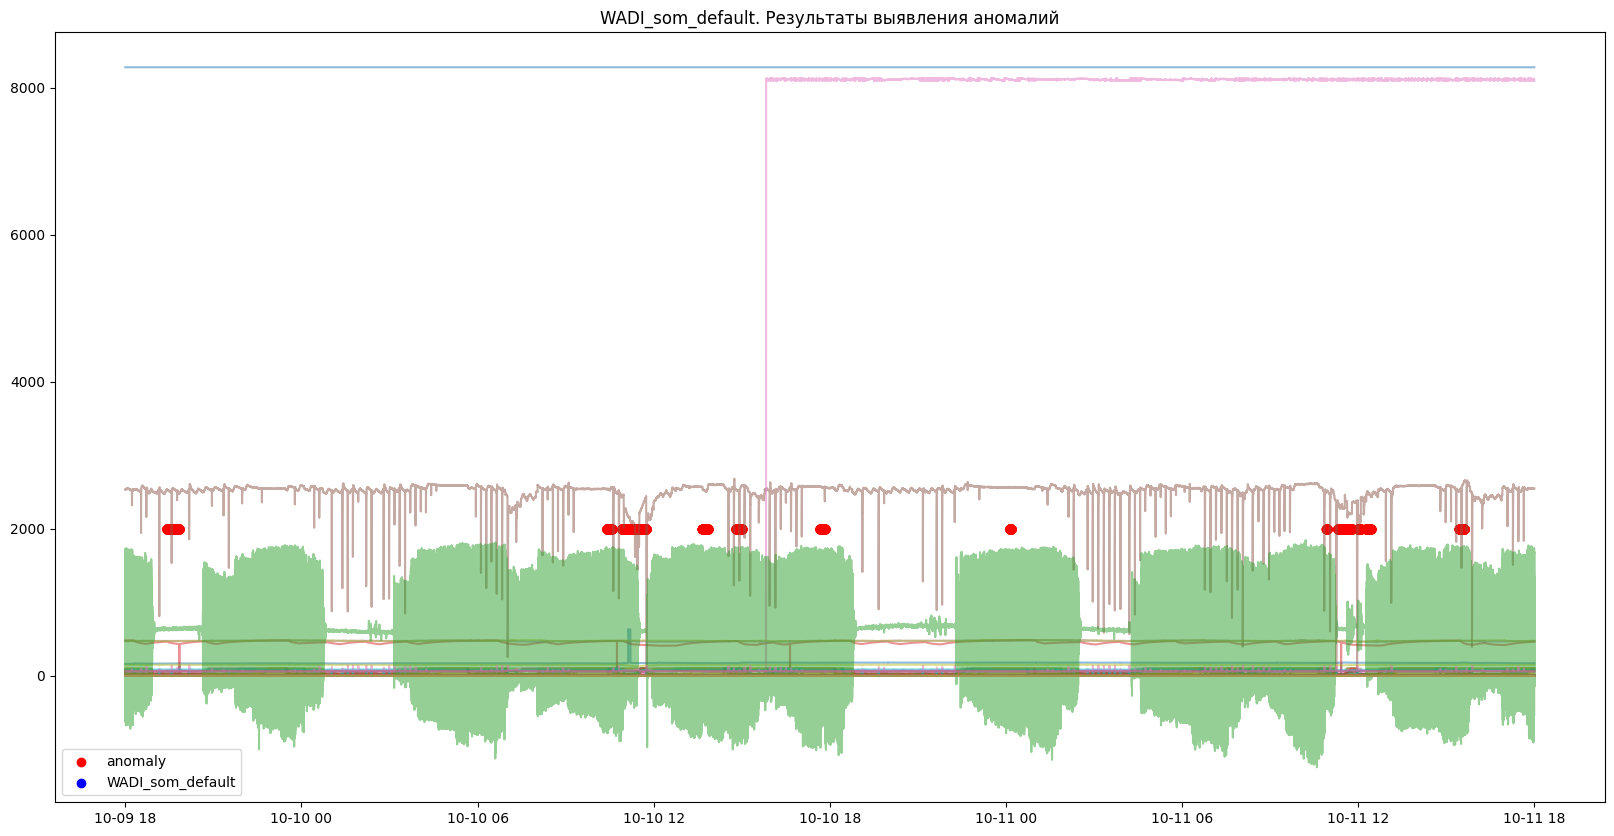

In [15]:
description = f'WADI_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

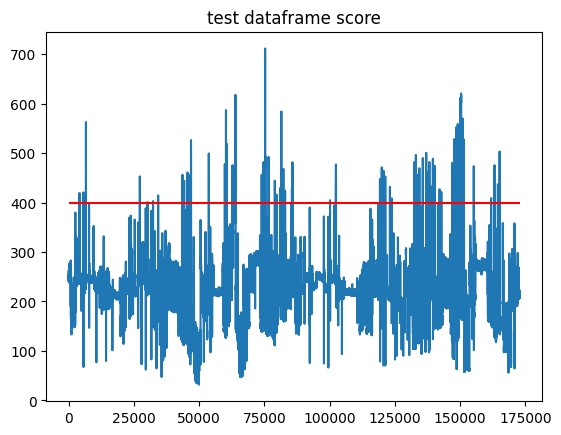

(172801,)
WADI_som_default
f1_score: 0.28
accuracy_score: 0.95
precision_score: 0.65
recall_score: 0.18


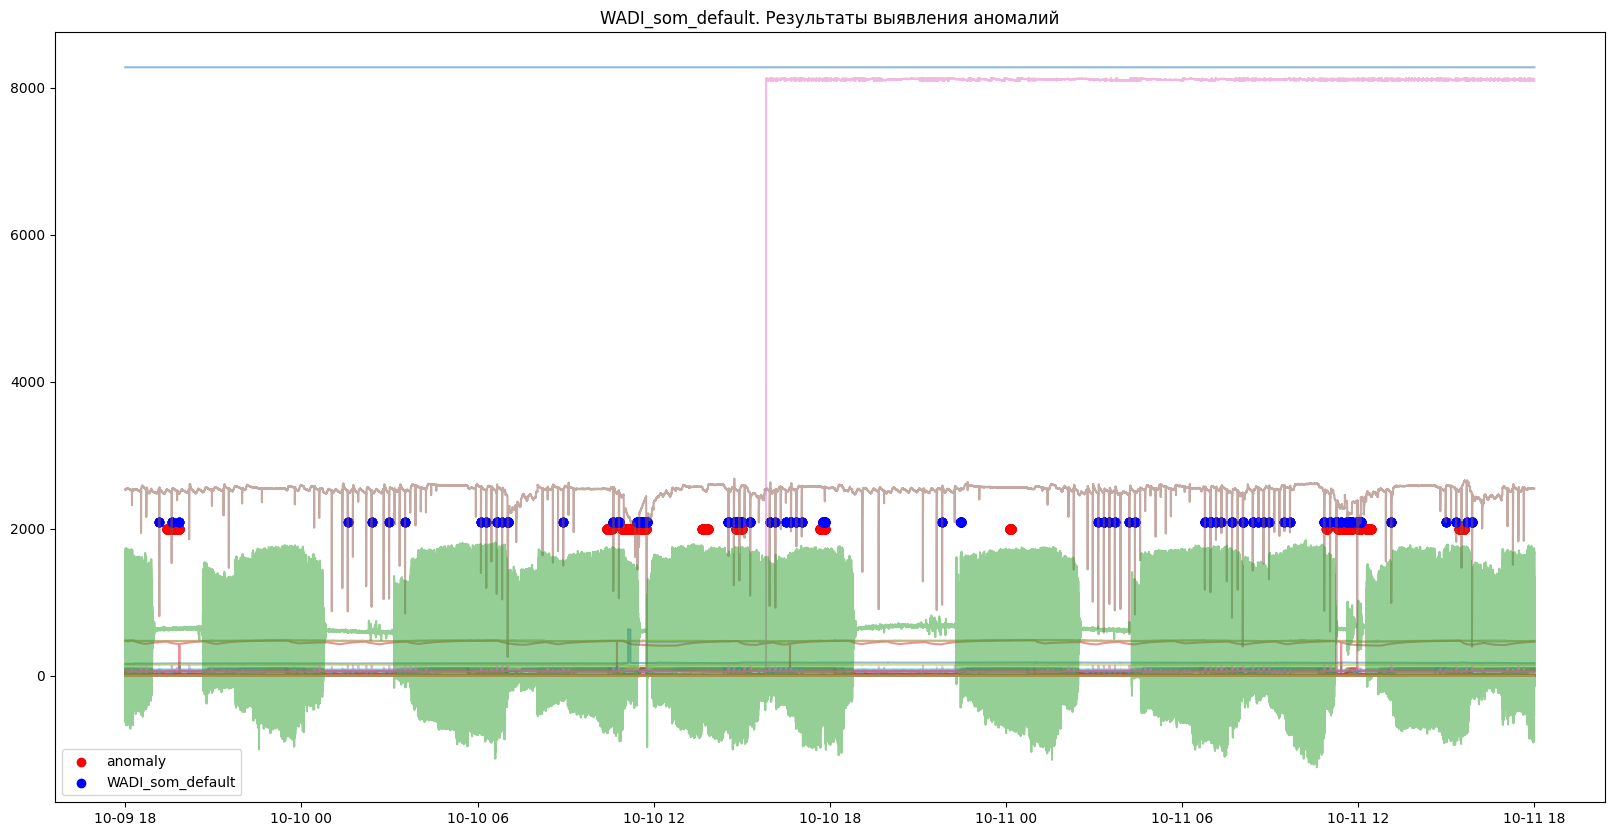

In [16]:
y_pred = predictor.get_anomalies(threshold=400)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Multiple models with pyod

In [10]:
test = df_test.copy().drop(bad_col, axis=1).dropna().resample("10S").mean()
test['anomaly'] =test['anomaly'].apply(lambda x: 0 if x<0.5 else 1)

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna().resample("10S").mean(), 
                                        test)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 16283, 1: 998})
Размеры выборок:
            x_train: (78458, 96)
            x_test: (17281, 96)
            y_test: (17281,)


2022-09-20 11:47:19.805096: can't find saved model, fit model...



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 34.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 34.8min finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 53.1min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 53.1min remaining:    0.0s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   33.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   33.3s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.2s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   15.1s finished


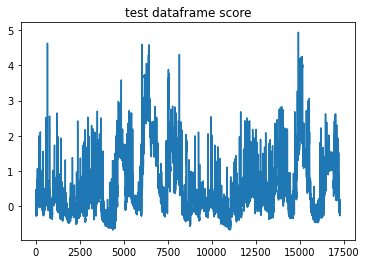

WADI_multi_models_pyod
f1_score: 0.30
accuracy_score: 0.83
precision_score: 0.19
recall_score: 0.64


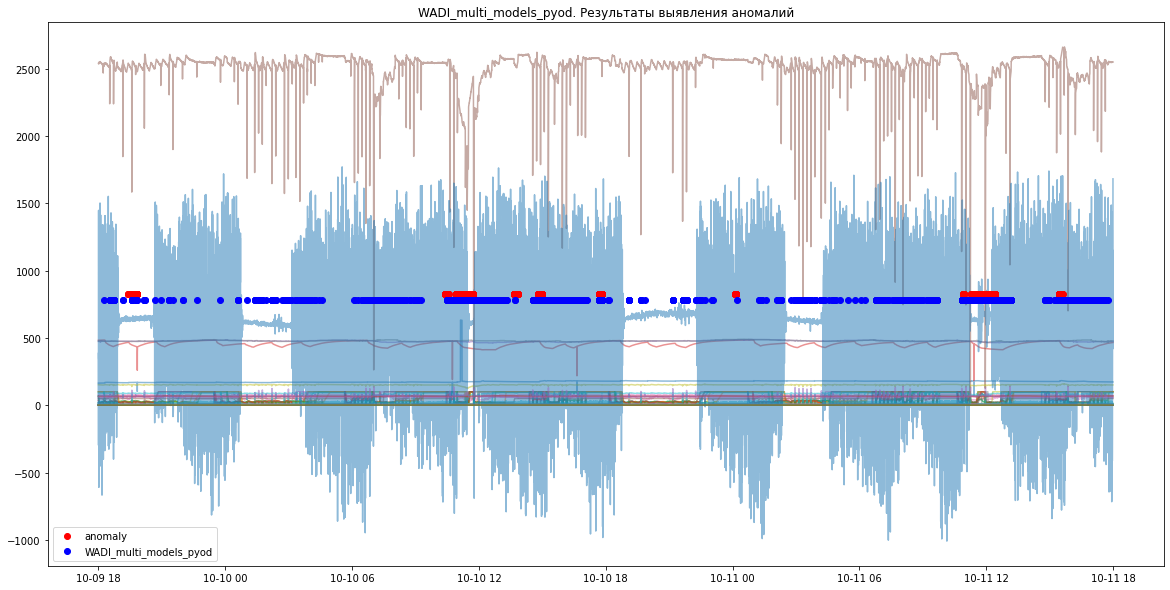

In [11]:
description = f'WADI_multi_models_pyod'

# initialized a group of outlier detectors for acceleration
detector_list = [PLOF(n_neighbors=25), PLOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=50)]

model = SU_OD(base_estimators=detector_list)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)
model.fit(x_train)
anomalies_predict = model.predict(x_test)

y_test = y_test
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(test, y_test, y_pred, descr=description)

## AutoEncoder in pyod

In [13]:
test = df_test.copy().drop(bad_col, axis=1).dropna().resample("10S").mean()
test['anomaly'] =test['anomaly'].apply(lambda x: 0 if x<0.5 else 1)

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna().resample("10S").mean(), 
                                        test)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 16283, 1: 998})
Размеры выборок:
            x_train: (78458, 96)
            x_test: (17281, 96)
            y_test: (17281,)


2022-09-20 13:29:41.261492: can't find saved model, fit model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                9312      
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 78458)             7610426   
                                                                 
 dropout_2 (Dropout)         (None, 78458)             0         
                                                         

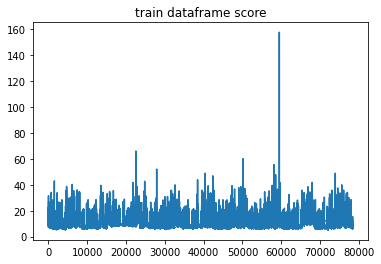

541/541 [==============================] - 19s 35ms/step


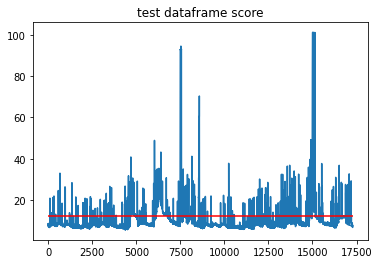

WADI_AutoEncoder_pyod
f1_score: 0.32
accuracy_score: 0.86
precision_score: 0.22
recall_score: 0.56


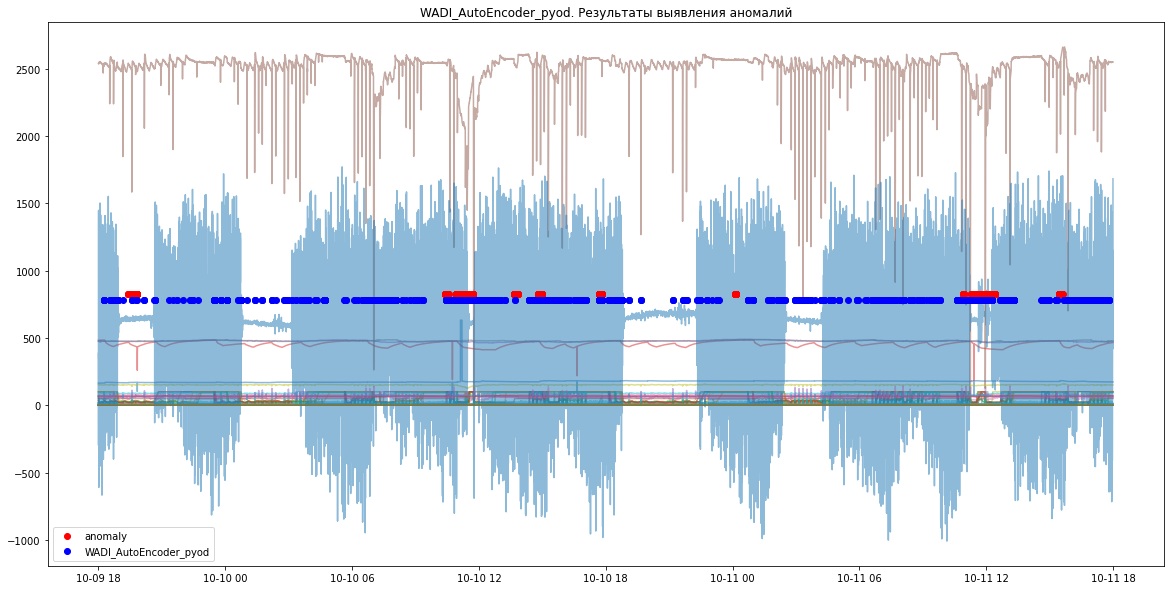

In [14]:
description = f'WADI_AutoEncoder_pyod'

model = AutoEnc(x_train, epochs=10)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(test, y_test, y_pred, descr=description)

## MO_GAAL in pyod

In [15]:
test = df_test.copy().drop(bad_col, axis=1).dropna().resample("10S").mean()
test['anomaly'] =test['anomaly'].apply(lambda x: 0 if x<0.5 else 1)

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna().resample("10S").mean(), 
                                        test)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 16283, 1: 998})
Размеры выборок:
            x_train: (78458, 96)
            x_test: (17281, 96)
            y_test: (17281,)


2022-09-20 16:51:44.429430: can't find saved model, fit model...
Epoch 1 of 6

Testing for epoch 1 index 1:
2452/2452 [==============================] - 4s 2ms/step

Testing for epoch 1 index 2:
2452/2452 [==============================] - 6s 2ms/step

Testing for epoch 1 index 3:
2452/2452 [==============================] - 6s 3ms/step

Testing for epoch 1 index 4:
2452/2452 [==============================] - 11s 4ms/step

Testing for epoch 1 index 5:
2452/2452 [==============================] - 10s 4ms/step

Testing for epoch 1 index 6:
2452/2452 [==============================] - 11s 4ms/step

Testing for epoch 1 index 7:
2452/2452 [==============================] - 7s 3ms/step

Testing for epoch 1 index 8:
2452/2452 [==============================] - 8s 3ms/step

Testing for epoch 1 index 9:
2452/2452 [==============================] - 8s 3ms/step

Testing for epoch 1 index 10:
2452/2452 [==============================] - 8s 3ms/step

Testing for epoch 1 index 11:
2452/2452 [======

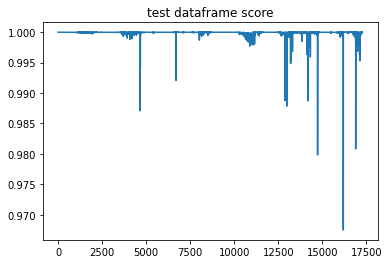

WADI_MO_GAAL_pyod
f1_score: 0.16
accuracy_score: 0.43
precision_score: 0.09
recall_score: 0.92


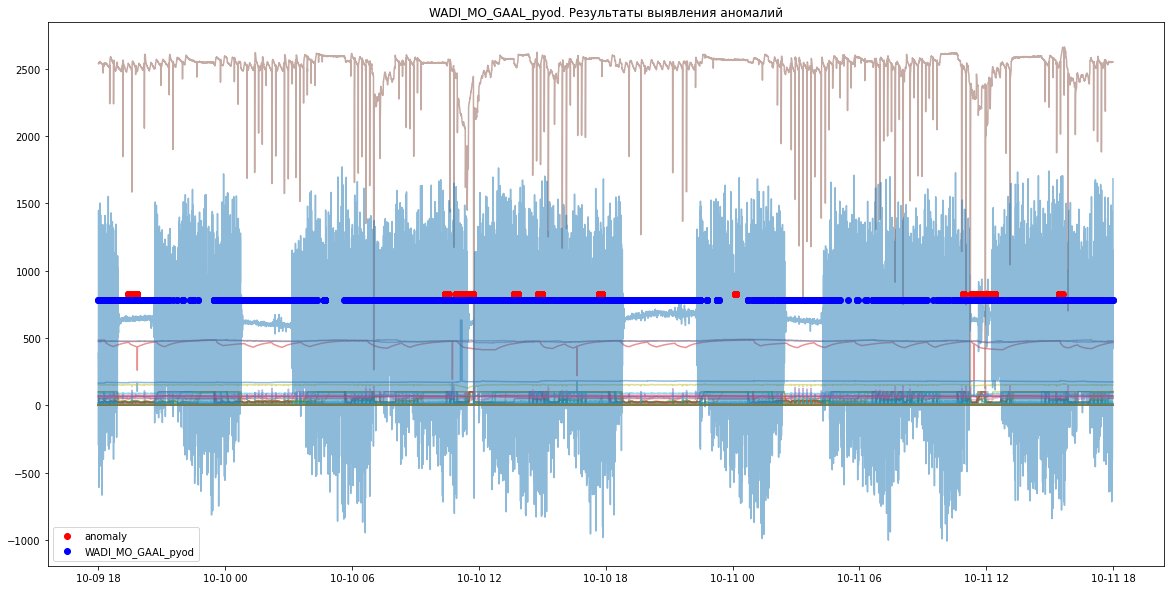

In [16]:
description = f'WADI_MO_GAAL_pyod'

model = MGAAL()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(test, y_test, y_pred, descr=description)

# Сводная таблица

In [17]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
#df_summary.style.format(precision=2).apply(highlight_max, props='color:white;background-color:darkblue', axis=0)
df_summary.style.format(precision=2).background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
WADI_multi_models_pyod,0.30,0.83,0.19,0.64
WADI_AutoEncoder_pyod,0.32,0.86,0.22,0.56
WADI_MO_GAAL_pyod,0.16,0.43,0.09,0.92
